<a href="https://colab.research.google.com/github/fmbento/Jupyter-Notebooks_ad-hoc-solutions/blob/main/Transcri%C3%A7%C3%A3o_de_Videos_ou_Audios_com_IA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transcrição de Vídeos ou Áudios com IA

Última revisão: <br>
28 Janeiro 2024 -- uso do **Faster-Whisper** em vez do Whisper (MUITO mais rápido)

### Na primeira execução vai aparecer este alerta:

<center>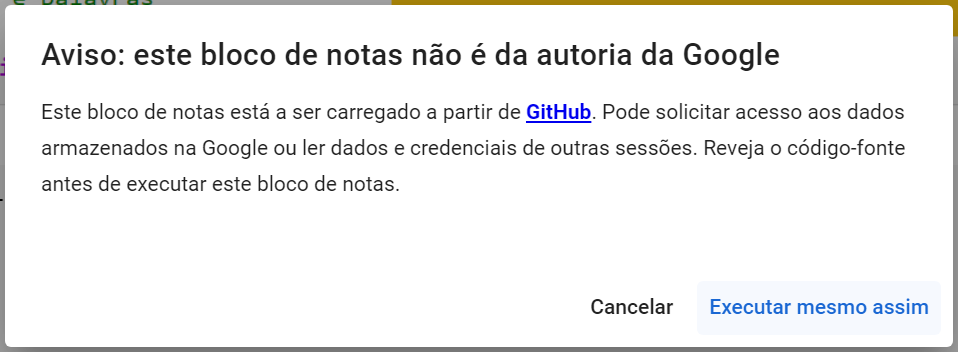</center>

Este notebook é seguro e pode escolher "Executar mesmo assim".


**Nota**: para o primeiro ficheiro vai demorar alguns 2 ou 3 minutos a mais (no Passo 2), pois na primeira execução precisa de fazer o download do modelo, 3.09 GB.



# Início:

In [ ]:
#@title Passo 0: Instala as bibliotecas Python necessárias

#@markdown Escolher um Tempo de Execução T4 (GPU NVidia Tesla T4)

#@markdown Só é necessário correr esta célula para o primeiro ficheiro, na sessão atual.

#@markdown NOTA: Se fechar esta página e não a abrir dentro de 10 a 15 minutos, todos os fichreiros e parametrizações serão apagados.

%%capture cap
!pip install faster-whisper pysubs2
!apt install libcublas11

In [ ]:
#@title Passo 1: Fazer o upload do ficheiro audio ou vídeo a transcrever

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  file_name = fn

In [ ]:
#@title Passo 2: Transcrição em frases na língua original do vídeo
#@markdown Irá fazer o download automático do ficheiro das legendas quando terminar.

#@markdown Para transcrever mais vídeos ou ficheiros aúdio, basta repetir o Passo 1 acima e este, novamente.

from faster_whisper import WhisperModel
import pysubs2
import os

model_size = "large-v2"

# Run on GPU with FP16
model = WhisperModel(model_size, device="cuda", compute_type="float16")

# or run on GPU with INT8
# model = WhisperModel(model_size, device="cuda", compute_type="int8_float16")
# or run on CPU with INT8
# model = WhisperModel(model_size, device="cpu", compute_type="int8")

segments, info = model.transcribe(file_name, beam_size=5)


# Caso esteja em PT e se queira traduzir para Inglês (comentar a instrução anterior)
# segments, info = model.transcribe(file_name, beam_size=5, language="en")


print("Língua detectada: '%s' -- probabilidade de %f"% (info.language, info.language_probability))

results= []
results2= []

for segment in segments:
    try:
      print("[%.2fs -> %.2fs] %s" % (segment.start, segment.end, segment.text))
      segment_dict = {'start':segment.start,'end':segment.end,'text':segment.text}
      results.append(segment_dict)
    except Exception as e:
        print(f"Oops... erro: {e}. Sem problema, vou avançar para a próxima frase.")

# Separar o nome do arquivo da sua extensão
base_name, extension = os.path.splitext(file_name)

# Altera o nome do ficheiro para conter o idioma reconhecido e a extensão .srt
srt_file_name = f"{base_name}.{info.language}.srt"

subs = pysubs2.load_from_whisper(results)
#save srt file
subs.save(srt_file_name)

import time
from google.colab import files
files.download(srt_file_name)

In [ ]:
#@title ... passo 2 alternativo: Caso acima não tenha detectado Português como o idioma, força-o para Português
#@markdown Irá fazer o download automático do ficheiro das legendas quando terminar.

from faster_whisper import WhisperModel
import pysubs2
import os

model_size = "large-v2"

# Run on GPU with FP16
model = WhisperModel(model_size, device="cuda", compute_type="float16")

# or run on GPU with INT8
# model = WhisperModel(model_size, device="cuda", compute_type="int8_float16")
# or run on CPU with INT8
# model = WhisperModel(model_size, device="cpu", compute_type="int8")

segments, info = model.transcribe(file_name, beam_size=5, language="pt")


# Caso esteja em PT e se queira traduzir para Inglês (comentar a instrução anterior)
# segments, info = model.transcribe(file_name, beam_size=5, language="en")


print("Língua detectada: '%s' -- probabilidade de %f"% (info.language, info.language_probability))

results= []
results2= []

for segment in segments:
    try:
      print("[%.2fs -> %.2fs] %s" % (segment.start, segment.end, segment.text))
      segment_dict = {'start':segment.start,'end':segment.end,'text':segment.text}
      results.append(segment_dict)
    except Exception as e:
        print(f"Oops... erro: {e}. Sem problema, vou avançar para a próxima frase.")

# Separar o nome do arquivo da sua extensão
base_name, extension = os.path.splitext(file_name)

# Altera o nome do ficheiro para conter o idioma reconhecido e a extensão .srt
srt_file_name = f"{base_name}.{info.language}.srt"

subs = pysubs2.load_from_whisper(results)
#save srt file
subs.save(srt_file_name)

import time
from google.colab import files
files.download(srt_file_name)

### **Extra 1: vídeo com legendas "queimadas"**
#### Nota, na célula "Passo 1", a fonte deverá ter sido um vídeo e não apenas um ficheiro aúdio

##### Caso seja necessário editar/corrigir as legendas, abrir o respectivo ficheiro .srt (clicar no icon \"ficheiros\" do lado esquerdo, por debaixo da \"chave\"), fazer as necessárias alterações e fechar ( = gravar) antes de correr a célula do Passo 1 abaixo.

In [ ]:
#@title Extra 1 - Passo 0: Instala biblioteca necessária
#@markdown Só é necessário ser corrida da primeira vez / primeiro ficheiro em cada sessão.
%%capture
!pip install ffmpeg-python

In [ ]:
#@title Extra 1 - Passo 1: Gera Vídeo legendado
#@markdown Esperar que processe o vídeo -- irá fazer o download automático do ficheiro legendado.

#@markdown Se aparecer uma notificação que o browser está a tentar fazer o download ao mesmo tempo de vários ficheiros, escolher "Permitir" / "Allow".

import ffmpeg

def queimar_legendas(caminho_video, caminho_legendas, caminho_saida):
    # Carregar o vídeo
    video_entrada = ffmpeg.input(caminho_video)
    # Incorporar as legendas no vídeo
    video_saida = ffmpeg.output(video_entrada, caminho_saida, vf='subtitles=' + caminho_legendas)
    # Executar o comando
    video_saida.run()


# Separar o nome do arquivo da sua extensão
base_name, extension = os.path.splitext(file_name)

# Adiciona "legendado" antes da extensão
new_file_name = f"{base_name}_legendado_{info.language}{extension}"

# Chamar a função com os seus caminhos de vídeo, legendas e saída
queimar_legendas(file_name, srt_file_name, new_file_name)
files.download(new_file_name)


### **Extra 2: Ficheiro de legendas em Inglês**

In [ ]:
#@title Transcrição em frases, tradução automática para Inglês caso o idioma original não seja EN.
#@markdown Para se gerar um ficheiro vídeo com as legendas em Inglês "queimadas" na imagem, basta executar a célula anterior ("Extra 1 - Passo 1: Gera Vídeo legendado"), após esta.

from faster_whisper import WhisperModel
import pysubs2

model_size = "large-v2"

# Run on GPU with FP16
model = WhisperModel(model_size, device="cuda", compute_type="float16")

# or run on GPU with INT8
# model = WhisperModel(model_size, device="cuda", compute_type="int8_float16")
# or run on CPU with INT8
# model = WhisperModel(model_size, device="cpu", compute_type="int8")

# segments, info = model.transcribe(file_name, beam_size=5)


# Caso esteja em PT e se queira traduzir para Inglês (comentar a instrução anterior)
segments, info = model.transcribe(file_name, beam_size=5, language="en")


print("Língua detectada: '%s' -- probabilidade de %f"% (info.language, info.language_probability))

results= []
results2= []

for segment in segments:
    try:
      print("[%.2fs -> %.2fs] %s" % (segment.start, segment.end, segment.text))
      segment_dict = {'start':segment.start,'end':segment.end,'text':segment.text}
      results.append(segment_dict)
    except Exception as e:
        print(f"Oops... erro: {e}. Sem problema, vou avançar para a próxima frase.")

# Separar o nome do arquivo da sua extensão
base_name, extension = os.path.splitext(file_name)

# Altera o nome do ficheiro para conter o idioma reconhecido e a extensão .srt
srt_file_name = f"{base_name}.{info.language}.srt"

subs = pysubs2.load_from_whisper(results)
#save srt file
subs.save(srt_file_name)

import time
from google.colab import files
files.download(srt_file_name)


---
---
***

> Para fazer a legendagem de mais vídeos, basta voltar a executar a célula "Passo 1: Fazer o upload do ficheiro audio ou vídeo a transcrever".

